<a href="https://colab.research.google.com/github/subu0106/Vehicle-Detection-and-License-Plate-Recognition/blob/main/Vehicle_Detection_and_License_Plate_Recognition_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install ultralytics opencv-python-headless numpy pytesseract
!apt-get install -y tesseract-ocr
!apt-get install -y libtesseract-dev



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.1/872.1 kB 22.0 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (6,020 kB/s)
Selecting

In [4]:
import cv2
import numpy as np
from ultralytics import YOLO
import pytesseract
from matplotlib import pyplot as plt
import os
import pandas as pd


In [5]:
import xml.etree.ElementTree as xet
from glob import glob
import re
import cv2

In [6]:
# File Path Link
dataset_path = '/content/drive/MyDrive/Car_NumberPlate'
match = re.search(r'\d+',"filename123.html")
match.group()

'123'

In [7]:
# Creating a Function which will return number from the file
def num_in_name(filename):
    """This will find number in the file if not no. then return 0"""
    match = re.search(r'\d+',filename)

    if match:
        return int(match.group(0))
    else:
        return 0

In [8]:
# This will select every file name whose extension end with xml
filename = glob(f"{dataset_path}/annotations/*.xml")
len(filename), filename[0]

(433, '/content/drive/MyDrive/Car_NumberPlate/annotations/Cars0.xml')

In [9]:
#Creating a dictionary for storing Data
data_dict = dict(img_path=[],
    xmin=[], ymin=[],
    xmax=[], ymax=[],
    img_w=[], img_h=[])

filepaths = glob(f"{dataset_path}/annotations/*.xml")

# arranging filepaths name accending order according to name:

for filepath in sorted(filepaths, key=num_in_name):
    parser = xet.parse(filepath)
    root = parser.getroot()

    objectData = root.find("object")
    bndbox = objectData.find("bndbox")

    xmin = int(bndbox.find("xmin").text)
    ymin = int(bndbox.find("ymin").text)
    xmax = int(bndbox.find("xmax").text)
    ymax = int(bndbox.find("ymax").text)

    # Get the image filename and construct the full path to the image
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)

    imgTensor = cv2.imread(img_path)
    height, width, _ = imgTensor.shape

    # saving info into dict
    data_dict["img_path"].append(img_path)
    data_dict["xmin"].append(xmin)
    data_dict["ymin"].append(ymin)
    data_dict["xmax"].append(xmax)
    data_dict["ymax"].append(ymax)
    data_dict["img_w"].append(width)
    data_dict["img_h"].append(height)

# Creating DataFrame
df = pd.DataFrame(data_dict)
df.head()





,img_path,xmin,ymin,xmax,ymax,img_w,img_h
0,/content/drive/MyDrive/Car_NumberPlate/images/...,226,125,419,173,500,268
1,/content/drive/MyDrive/Car_NumberPlate/images/...,134,128,262,160,400,248
2,/content/drive/MyDrive/Car_NumberPlate/images/...,229,176,270,193,400,400
3,/content/drive/MyDrive/Car_NumberPlate/images/...,142,128,261,157,400,225
4,/content/drive/MyDrive/Car_NumberPlate/images/...,156,82,503,253,590,350


In [10]:
# Testing working of glob function and shorting file according to number in name in accending order
filepaths = glob(f"{dataset_path}/annotations/*.xml")
num=0
for filepath in sorted(filepaths, key=num_in_name):
    if num==4:
        break
    num+=1
    print(filepath)

/content/drive/MyDrive/Car_NumberPlate/annotations/Cars0.xml
/content/drive/MyDrive/Car_NumberPlate/annotations/Cars1.xml
/content/drive/MyDrive/Car_NumberPlate/annotations/Cars2.xml
/content/drive/MyDrive/Car_NumberPlate/annotations/Cars3.xml


In [11]:
# Taking 10 % of data as we have limited images for trainning a model.
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.1, random_state=42)

train, val = train_test_split(train, test_size=1/9, random_state=42)

train.shape, test.shape, val.shape

((345, 7), (44, 7), (44, 7))

In [12]:
import shutil

# Remove the 'datasets' directory if it exists
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

In [13]:
def create_yolo_folder(name,dataframe):
    """ - This Function will create Label and Image directory for Train, Test and Validation data
        - It also convert df to text according to yolo standards
    """

    # creating directory for labels and images
    labels_path = os.path.join("datasets","car_plate",name,"labels")
    image_path = os.path.join("datasets","car_plate",name,"images")

    # this will create all folders
    os.makedirs(labels_path,exist_ok=True)
    os.makedirs(image_path,exist_ok=True)

    # this will iterate through dataset and extract image name, and center for bbox
    for _,row in dataframe.iterrows():

        image_name, image_extension = os.path.splitext(os.path.basename(row["img_path"]))

        x_center = (row["xmin"] + row["xmax"])/2/row["img_w"]
        y_center = (row["ymin"] + row["ymax"])/2/row["img_h"]
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']


        # saving data into yolo formate
        label_path = os.path.join(labels_path, f"{image_name}.txt")

        with open(label_path,"w") as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")

        # moving Image from given path to new directory
        shutil.copy(row["img_path"],os.path.join(image_path,image_name+image_extension))

    print(f"Created '{image_path}' and '{label_path}'")


In [14]:
# creating train, test and validation folders
create_yolo_folder("train",train)
create_yolo_folder("test",test)
create_yolo_folder("validation",val)

Created 'datasets/car_plate/train/images' and 'datasets/car_plate/train/labels/Cars199.txt'
Created 'datasets/car_plate/test/images' and 'datasets/car_plate/test/labels/Cars73.txt'
Created 'datasets/car_plate/validation/images' and 'datasets/car_plate/validation/labels/Cars237.txt'


In [15]:
import random
os.getcwd()

'/content'

100%|██████████| 6.25M/6.25M [00:00<00:00, 98.1MB/s]



image 1/1 /content/datasets/car_plate/train/images/Cars299.png: 480x640 1 car, 505.3ms
Speed: 16.7ms preprocess, 505.3ms inference, 28.6ms postprocess per image at shape (1, 3, 480, 640)


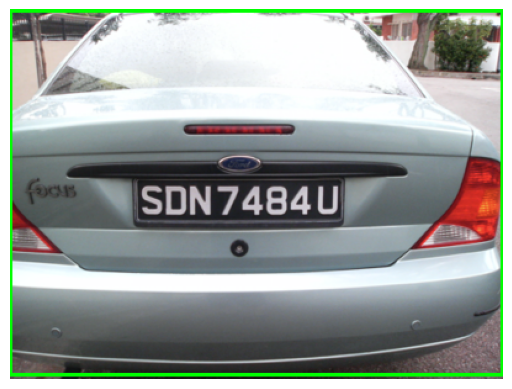

In [16]:

# Directory paths
image_dir = "datasets/car_plate/train/images"
labels_dir = "datasets/car_plate/train/labels"

# Load YOLOv8 model (adjust the model path as needed)
model = YOLO('yolov8n.pt')

def get_vehicle_image(image_name):
    # Get the image and label paths
    image_path = os.path.join(image_dir, image_name)
    label_path = os.path.join(labels_dir, f"{os.path.splitext(image_name)[0]}.txt")

    # Load and convert the image to RGB
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform vehicle detection using YOLOv8
    results = model(image_path)  # Run inference on the image
    detections = results[0]  # Get the detection results

    # Draw bounding boxes and labels on the image
    for box in detections.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
        confidence = box.conf[0]  # Confidence score

        # Draw bounding box
        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Draw confidence score
        cv2.putText(image_rgb, f'{confidence*100:.2f}%', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Display the image with bounding boxes using Matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image

image_list = os.listdir(image_dir)
#Extracting Random image from train folder
random_vehicle = random.choice(image_list)
get_vehicle_image(random_vehicle)


0.0 0.4637 0.52 0.4225 0.1333


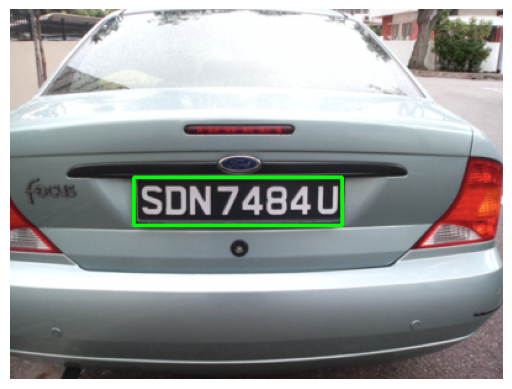

In [17]:
def get_numberplate_image(image_name):

    image_path = os.path.join(image_dir, image_name)
    label_path = os.path.join(labels_dir, f"{os.path.splitext(image_name)[0]}.txt")

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    with open(label_path,"r") as file:
        lines = file.readlines()

    for line in lines:
        class_id,x_center,y_center,width,height = map(float, line.strip().split())
        print(class_id,x_center,y_center,width,height)


        image_height, image_width, _ = image.shape
        #print(image_h,image_w)

        # getting Dimension of BBox
        x_center *= image_width
        y_center *= image_height
        width *= image_width
        height *= image_height
        #print(x_center,y_center,width,height)

        # Calculating the top and bottom x and y point of bbox
        x1 = int(x_center - width/2)
        y1 = int(y_center - height/2)
        x2 = int(x_center + width/2)
        y2 = int(y_center + height/2)

        #print(x1,y1, x2, y2,)

        # Draw the bounding box on the image using a green rectangle
        cv2.rectangle(img=image, pt1=(x1, y1), pt2=(x2, y2), color=(0, 255, 0), thickness=2)


    # Display the image with bounding box using matplotlib
    plt.imshow(image)
    plt.axis('off')
    plt.show()  # Display the image

get_numberplate_image(random_vehicle)

In [18]:
# creating dataset.ymal file
dataset_yaml = """

# root dir
path: car_plate

# Directories
train: train/images
val: validation/images
test: test/images

# number of class
nc: 1

# class name
names: ['licence_plate']

"""

with open("datasets.yaml","w") as file:
    file.write(dataset_yaml)

In [19]:
!pip install -U ultralytics -q -i https://pypi.org/simple

In [20]:
!pip install -U ipywidgets

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 44.3 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.8
    Uninstalling widgetsnbextension-3.6.8:
      Successfully uninstalled widgetsnbextension-3.6.8
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [21]:
# I am using nano version as it is small and my dataset is small
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

In [22]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.1 MB/s eta 0:00:00


In [23]:
import os
import wandb

# Set the API key manually
os.environ["WANDB_API_KEY"] = "bae331001ffe101c970b75e0a719b819e57483ef"

# Login to WandB
wandb.login()


wandb: Currently logged in as: subu20010601 (subu20010601-university-of-moratuwa). Use `wandb login --relogin` to force relogin


True

In [24]:
# trainning model using datasets.yaml file
model.train(
    data="datasets.yaml",
    epochs=50,
    batch=16,
    device="cpu",
    imgsz=320,
    cache=True # for fast trainning
)

Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cpu, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

100%|██████████| 755k/755k [00:00<00:00, 17.6MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Freezing layer 'model.22.dfl.conv.weight'


train: Scanning /content/datasets/car_plate/train/labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:01<00:00, 269.96it/s]

train: New cache created: /content/datasets/car_plate/train/labels.cache



train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:08<00:00, 39.49it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/car_plate/validation/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 763.83it/s]

val: New cache created: /content/datasets/car_plate/validation/labels.cache



val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 68.49it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.666      2.813      1.271         21        320: 100%|██████████| 22/22 [01:24<00:00,  3.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]

                   all         44         44    0.00368      0.932      0.353      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.542      1.583      1.119         13        320: 100%|██████████| 22/22 [01:20<00:00,  3.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.79s/it]

                   all         44         44          1       0.15      0.612      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.473      1.375       1.14         22        320: 100%|██████████| 22/22 [01:19<00:00,  3.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]

                   all         44         44      0.148     0.0281     0.0605     0.0329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.477       1.34      1.135         16        320: 100%|██████████| 22/22 [01:18<00:00,  3.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]

                   all         44         44      0.386      0.318      0.315      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.478      1.227      1.173         15        320: 100%|██████████| 22/22 [01:22<00:00,  3.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.92s/it]

                   all         44         44          1      0.043      0.152     0.0562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.514      1.273      1.192         17        320: 100%|██████████| 22/22 [01:16<00:00,  3.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]

                   all         44         44       0.81       0.75      0.783        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.488      1.182      1.144         20        320: 100%|██████████| 22/22 [01:18<00:00,  3.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]

                   all         44         44      0.727       0.75      0.704      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.455      1.098      1.148         19        320: 100%|██████████| 22/22 [01:17<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.89s/it]

                   all         44         44      0.668      0.614      0.641      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.381      1.068      1.138         12        320: 100%|██████████| 22/22 [01:26<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]

                   all         44         44       0.87      0.795      0.862      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.361      1.036      1.106         18        320: 100%|██████████| 22/22 [01:19<00:00,  3.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]

                   all         44         44      0.805      0.795      0.837      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.389      1.025       1.13         10        320: 100%|██████████| 22/22 [01:17<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]

                   all         44         44      0.901       0.83      0.888      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.336     0.9904      1.082         15        320: 100%|██████████| 22/22 [01:15<00:00,  3.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.07s/it]

                   all         44         44      0.922      0.801      0.882      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.288     0.9149      1.079         20        320: 100%|██████████| 22/22 [01:17<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]

                   all         44         44       0.83      0.886      0.843      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.315     0.9081      1.081         25        320: 100%|██████████| 22/22 [01:17<00:00,  3.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]

                   all         44         44      0.951       0.88      0.901      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.238     0.8707      1.055         23        320: 100%|██████████| 22/22 [01:21<00:00,  3.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]

                   all         44         44      0.883       0.86      0.874       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.226     0.8417      1.062         17        320: 100%|██████████| 22/22 [01:17<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]

                   all         44         44      0.871      0.864      0.853      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.212     0.8315      1.061         18        320: 100%|██████████| 22/22 [01:18<00:00,  3.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]

                   all         44         44      0.857      0.815      0.822      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.237      0.813      1.056         19        320: 100%|██████████| 22/22 [01:16<00:00,  3.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]

                   all         44         44      0.907      0.705      0.869      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.231     0.8151      1.068         19        320: 100%|██████████| 22/22 [01:18<00:00,  3.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]

                   all         44         44      0.899      0.886      0.932       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.163     0.7771      1.036         18        320: 100%|██████████| 22/22 [01:17<00:00,  3.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]

                   all         44         44      0.883      0.841      0.888      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.176     0.7901      1.034         16        320: 100%|██████████| 22/22 [01:20<00:00,  3.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]

                   all         44         44      0.833      0.841      0.855      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.132     0.7487      1.022         19        320: 100%|██████████| 22/22 [01:17<00:00,  3.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]

                   all         44         44      0.919      0.841      0.901      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.174     0.7541       1.02         19        320: 100%|██████████| 22/22 [01:18<00:00,  3.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.66s/it]

                   all         44         44      0.874      0.909      0.924      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.198      0.774      1.033         25        320: 100%|██████████| 22/22 [01:16<00:00,  3.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.06s/it]

                   all         44         44      0.861      0.846      0.897      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.103     0.7277     0.9908         18        320: 100%|██████████| 22/22 [01:19<00:00,  3.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]

                   all         44         44      0.906       0.88      0.928      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.145     0.7049       1.02         20        320: 100%|██████████| 22/22 [01:17<00:00,  3.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]

                   all         44         44      0.875      0.795      0.881      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.108     0.7165      1.003         20        320: 100%|██████████| 22/22 [01:19<00:00,  3.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.50s/it]

                   all         44         44       0.93      0.795      0.886      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.053     0.6901     0.9936         15        320: 100%|██████████| 22/22 [01:24<00:00,  3.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]

                   all         44         44      0.958      0.795      0.915      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G       1.12     0.6919     0.9943         20        320: 100%|██████████| 22/22 [01:31<00:00,  4.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]

                   all         44         44      0.866      0.886      0.899      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.053     0.6642     0.9815         12        320: 100%|██████████| 22/22 [01:28<00:00,  4.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.55s/it]

                   all         44         44      0.957      0.818      0.895      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.047     0.6475     0.9725         20        320: 100%|██████████| 22/22 [01:31<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]

                   all         44         44      0.947      0.816      0.916      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.072     0.6616     0.9926         12        320: 100%|██████████| 22/22 [01:31<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.07s/it]

                   all         44         44      0.851      0.841      0.885      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.006     0.6335     0.9642         18        320: 100%|██████████| 22/22 [01:31<00:00,  4.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]

                   all         44         44      0.871      0.841      0.902      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.018      0.622     0.9776         17        320: 100%|██████████| 22/22 [01:27<00:00,  4.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.89s/it]

                   all         44         44      0.877      0.864      0.916      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.9793      0.606     0.9656         21        320: 100%|██████████| 22/22 [01:30<00:00,  4.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]

                   all         44         44      0.977      0.773       0.92      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.9981     0.6003      0.971         21        320: 100%|██████████| 22/22 [01:31<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]

                   all         44         44      0.965      0.886      0.933       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.9707     0.6063     0.9412         20        320: 100%|██████████| 22/22 [01:31<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]

                   all         44         44      0.971      0.841      0.922       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.9631     0.6117     0.9668         21        320: 100%|██████████| 22/22 [01:32<00:00,  4.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]

                   all         44         44      0.905       0.87      0.935      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.9553     0.6041      0.961         11        320: 100%|██████████| 22/22 [01:30<00:00,  4.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]

                   all         44         44      0.966      0.795       0.92      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.9445     0.5659     0.9548         25        320: 100%|██████████| 22/22 [01:31<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]

                   all         44         44      0.888      0.898      0.933      0.518


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.176     0.6631      1.044          9        320: 100%|██████████| 22/22 [01:29<00:00,  4.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]

                   all         44         44      0.907      0.886      0.936      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G       1.12     0.6402      1.016          9        320: 100%|██████████| 22/22 [01:29<00:00,  4.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]

                   all         44         44      0.918      0.841      0.929      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.082     0.6366      1.024          9        320: 100%|██████████| 22/22 [01:27<00:00,  3.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]

                   all         44         44      0.919      0.818      0.945      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.055     0.6165      1.022          9        320: 100%|██████████| 22/22 [01:29<00:00,  4.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]

                   all         44         44       0.97      0.818      0.913      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G       1.07     0.6117      1.005          9        320: 100%|██████████| 22/22 [01:25<00:00,  3.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.11s/it]

                   all         44         44      0.972      0.784      0.892      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G      1.064     0.5895      1.016          9        320: 100%|██████████| 22/22 [01:26<00:00,  3.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.35s/it]

                   all         44         44      0.972      0.794      0.897      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      1.013     0.5767       0.99          9        320: 100%|██████████| 22/22 [01:24<00:00,  3.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.81s/it]

                   all         44         44      0.976      0.773      0.894      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      1.011     0.5749     0.9954          9        320: 100%|██████████| 22/22 [01:27<00:00,  3.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]

                   all         44         44      0.965      0.795      0.908      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      1.003     0.5654     0.9697          9        320: 100%|██████████| 22/22 [01:27<00:00,  3.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]

                   all         44         44      0.946      0.795      0.904       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G       1.02      0.569     0.9801          9        320: 100%|██████████| 22/22 [01:31<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]

                   all         44         44      0.946      0.799      0.906      0.531



50 epochs completed in 1.223 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.82s/it]


                   all         44         44      0.907      0.886      0.936      0.538
Speed: 0.8ms preprocess, 78.1ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▂▄▆▇████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▂▄▆▇████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▂▄▆▇████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▃▅▁▃▇▆▆▇█▇▇█▇▇▇█▇███▇███████████████████
metrics/mAP50-95(B),▃▄▁▂▆▅▅▇▇▇▆▇▆▇▆▇▇▇▇▇▇█▇▇█▇▇▇████████████
metrics/precision(B),▁█▂▄▇▆▆▇▇▇▇█▇▇▇▇▇▇▇▇▇██▇█▇▇▇██▇█▇▇▇████▇
metrics/recall(B),█▂▁▃▇▇▆▇▇▇██▇▇▆█▇▇█▇▇▇▇█▇▇▇▇█▇█▇█▇▇▇▇▇▇█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▆▆▇▆▆▅▅▅▄▅▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▁▁▁▁▃▃▂▂▂▂▂▂


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f3f09caa7d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [25]:
# finding most recent directory
log_dir = max(glob("runs/detect/train*"),key=num_in_name)

# loding trainning result.csv
result_df = pd.read_csv(os.path.join(log_dir,"results.csv"))
result_df.columns = result_df.columns.str.strip()
result_df.head(3)

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.6660,2.8128,1.2707,0.00368,0.93182,0.35253,0.16210,1.5265,3.0177,1.1160,0.000420,0.000420,0.000420
1,2,1.5415,1.5829,1.1186,1.00000,0.15030,0.61221,0.27657,1.6415,2.7283,1.1473,0.000843,0.000843,0.000843
2,3,1.4729,1.3751,1.1404,0.14816,0.02814,0.06052,0.03288,1.7368,3.0773,1.4025,0.001249,0.001249,0.001249


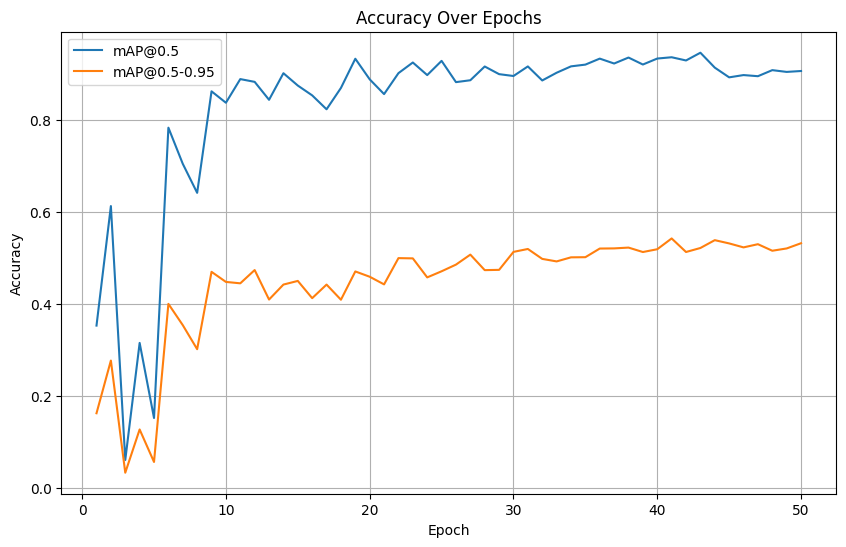

In [26]:
# extracting information from dataframe
epochs = result_df.index + 1 #as it start from 0

mAP_0_5 = result_df['metrics/mAP50(B)']  # Mean Average Precision at IoU=0.5
mAP_0_5_0_95 = result_df['metrics/mAP50-95(B)'] # Mean Average Precision at IoU=0.5:0.95

#plotting Accuracy over Epochs
plt.figure(figsize=(10,6))
plt.plot(epochs,mAP_0_5, label="mAP@0.5")
plt.plot(epochs,mAP_0_5_0_95, label="mAP@0.5-0.95")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Save the trained model
model.save('best_license_plate_model.pt')

In [28]:
import pytesseract
from pytesseract import Output

In [29]:
def PredictPlot(image_path):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    prediction = model.predict(image_path, device='cpu')
    #print(prediction)

    for result in prediction:
        for box in result.boxes:

            #getting x1, x2, y1, y2
            x1, y1, x2, y2 = map(int,box.xyxy[0])

            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

            # cropping Image
            roi = image[y1:y2,x1:x2]
            text = pytesseract.image_to_string(roi, config='--psm 6')
            print(f"Detected text: {text}")

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


image 1/1 /content/drive/MyDrive/Car_NumberPlate/images/Cars425.png: 160x320 1 licence_plate, 56.4ms
Speed: 2.7ms preprocess, 56.4ms inference, 1.0ms postprocess per image at shape (1, 3, 160, 320)
Detected text: G526 JHD



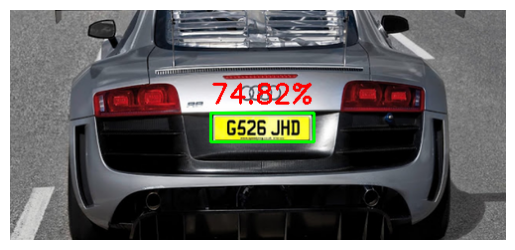

In [30]:

pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

# Now you can use your function
PredictPlot(test.iloc[0].img_path)



image 1/1 /content/drive/MyDrive/Car_NumberPlate/images/Cars126.png: 256x320 1 licence_plate, 82.0ms
Speed: 1.9ms preprocess, 82.0ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 320)
Detected text: KA pone 1722



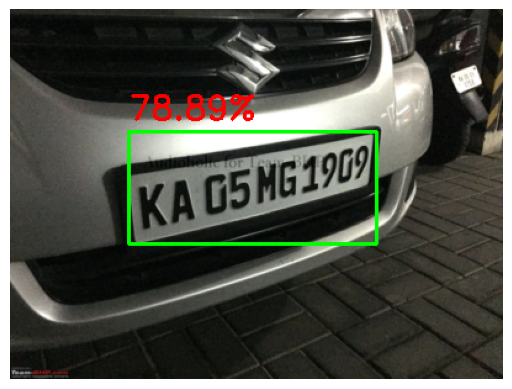

In [31]:
PredictPlot(test.iloc[30].img_path)